A note book for extracting ENA from trained RNNs

In [1]:
#%%
import numpy as np
import networkx as nx # for network analysis
from copy import deepcopy, copy
import random
from matplotlib import pyplot as plt
# %%
# def remove_two_loops(B):
#     '''
#     removes 2-loops 

#     2-loops are remove by severing one of the connections: the one leading to the
#     node with fewer number of outgoing direction except if the # of outgoing direction
#     is 1.  
#     '''
#     n = B.shape[0]
#     A = copy(B)
#     J = list()
#     for i in range(n):
#         for j in range(i+1, n):
#             if {i, j} not in J and A[i, j] + A[j, i] == 2:
#                 ix = [i, j]
#                 random.shuffle(ix)
#                 A[ix[0], ix[1]] = 0
#             J.append({i, j})
#     return A

def remove_two_loops(B):
    B = copy(B)
    n = B.shape[0]
    B2 = np.matmul(B, B)
    paths_of_2 = list(np.where(B2.diagonal())[0])
    index_tracker = list()
    while len(index_tracker) != len(paths_of_2):
        start = paths_of_2[0]
        end = list(np.where(B[start, :])[0])
        B[start, end] = 0
        index_tracker += [start] + end
    return B




def remove_delta_cliques(B):
    '''
    removes delta cliques by removing the shortest connnection between the nodes
    involved
    '''
    A = deepcopy(B)
    A2 = np.bool_(np.matmul(A, A))
    if A2.sum() != 0:
        indx = np.where(A + A2 == 2)
        A[indx[0], indx[1]] = 0
    return A

def in_neighbours(i, A):
    '''
    returns the in-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[:, i-1])[0]

def out_neighbours(i, A):
    '''
    returns the out-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[i-1, :])[0]

def intersection(list1, list2):
    return list(set(list1) & set(list2))

import networkx as nx
def convert_to_nx(A):
    '''
    converts A into a networkx digraph
    '''
    G = nx.DiGraph(directed=True)
    out = list()
    n = A.shape[0]
    # letters provide labelling
    LETTERS = [str(i) for i in range(n)]
    for i in range(n):
        out.extend([(LETTERS[i], LETTERS[k]) for k in np.where(A[i, :])[0]])
    G.add_edges_from(out)
    return G


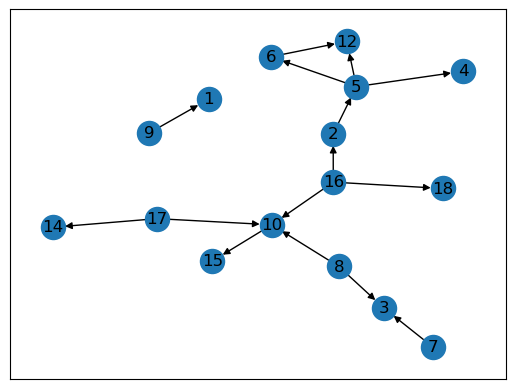

In [2]:
#%%
A = np.array([
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]])

B = remove_delta_cliques(A)


#%%
rnn_size = 20
sparsity = 0.9 * 1/rnn_size
A = np.random.binomial(1, sparsity, (rnn_size, rnn_size))
np.fill_diagonal(A, 0)
A = remove_two_loops(A)
# print(A)
#%%
G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

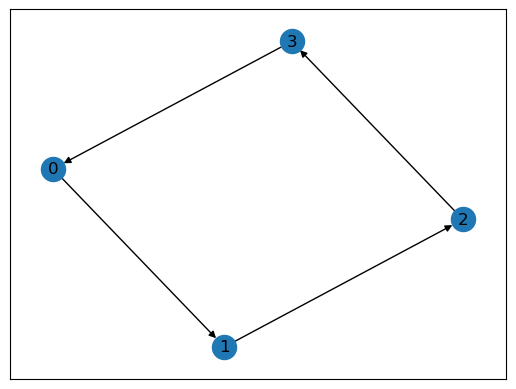

In [5]:
A = np.zeros((rnn_size, rnn_size))
A[:4, :4] = [[0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]]
G = convert_to_nx(A)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
# %%
A = np.array([
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0]])

In [6]:
import torch
from generate_flip_flop import *
import pickle
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)

keys = list(params.keys())
reservoir = params[keys[0]]
ridge = params[keys[1]]

Wr, Win, Wfb = torch.tensor(reservoir['W'].toarray()), \
                       torch.tensor(reservoir['Win'].toarray()), \
                       torch.tensor(reservoir['Wfb'].toarray())
# Wout = ridge['Wout']

In [7]:
# testing model
amplitude = 0.3
with open('train_test.pkl', 'rb') as f:
    x_train, y_train = pickle.load(f)
x_train = amplitude*x_train
y_train = amplitude*y_train

In [8]:
seed = 42
from reservoirpy.nodes import Reservoir, Ridge
n_neurons = 500
reservoir = Reservoir(n_neurons, sr=0.5, rc_connectivity=0.05, lr = 1, 
        input_bias=False, seed=42, input_scaling=1.2)
readout = Ridge(ridge=1e-4, input_bias=False)
# This force learning uses a single layer online neural network. 
# readout = FORCE(alpha=1e-6)


reservoir <<= readout  ## feedback
esn = reservoir >> readout
esn = esn.fit(x_train, y_train)

# readout.Wout = Wout
# reservoir.Wfb = Wfb
# reservoir.W = Wr

Running Model-0: 50000it [00:19, 2510.82it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:20<00:00, 20.11s/it]

Fitting node Ridge-0...


In [9]:
preds = esn.run(x_train)

Running Model-0: 50000it [00:13, 3692.00it/s]         


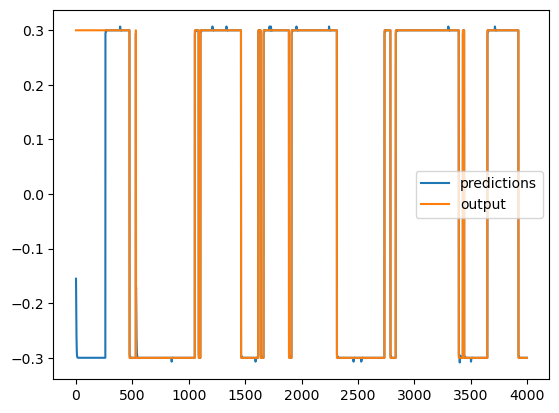

In [10]:
n_start = 0
n_steps = 4000
d = 0
plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
# plt.plot(x_train[n_start:(n_start + n_steps), d], 'r-', label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y_train[n_start:(n_start + n_steps), d], label='output')
plt.legend()
plt.show()

In [11]:
N_new = 10000
x_new, y_new, _ = sequence(N_new, 0.03, 1, 1)
x_new = amplitude*x_new
y_new = amplitude*y_new

In [12]:
pred_new_data = esn.run(x_new)

Running Model-0: 10000it [00:02, 3700.79it/s]         


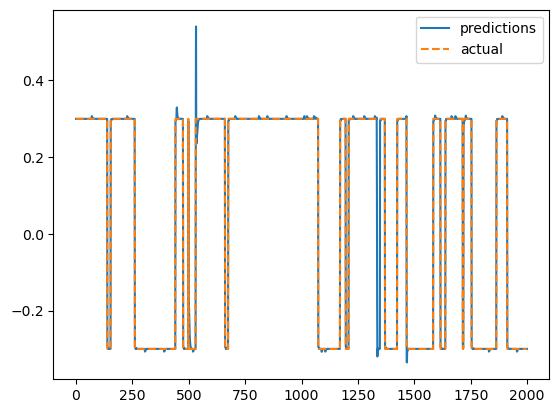

In [13]:
n_start = 0
# n_steps = x_test.shape[0]
n_steps = 2000
d = 0
plt.plot(pred_new_data[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_new[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
# plt.plot(x_new[n_start:(n_start + n_steps), d], label='input', linestyle='-.')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [14]:
import torch
import torch.nn as nn

def weight_matrix(A, p, w_p):
    w_m, w_s, w_t = p
    return w_s + (w_s - w_t)*torch.eye(A.shape[0]) + (w_p - w_t)*A.T + (w_m - w_t)*A

def activation(x, beta):
    return 1/(1+torch.exp(-beta*(x-0.5)))

def cutt_off(x):
    cond1 = x <= 0
    cond2 = x > 0
    x[cond1] = 0
    x[cond2] =  torch.exp(-1/x[cond2])
    return x

def c_activation(x, beta):
    c = cutt_off(x)
    return c/(c + cutt_off(1-x))


In [59]:
class ENA_extractor(nn.Module):
    def __init__(self, k, beta_init, p_init, Wp, n_out, n_in, scalings, A):
        '''
        n: dimension of phase space
        beta_init: initial value of the gain parameter in 
                
                y = 1/(1+exp(-beta*x))
        p_init: contain the initial values of floats w_m, w_p, w_s, w_t in that
        order.
        A: gives the adjacency matrix
        scalings: contained scalings for Win, Wout, Wfb in that other
        '''
        super().__init__()
        # if A is None:
        #     A = np.random.binomial(1, sparsity, (n,n))
        #     np.fill_diagonal(A, 0)
        #     A = remove_two_loops(A)
        self.A = A
        self.n = A.shape[0]
        self.n_in = n_in
        self.n_out = n_out
        # self.scalings = torch.nn.Parameter(scalings.requires_grad_())
        self.scalings = scalings
        self.p = torch.nn.Parameter(p_init.requires_grad_())
        # self.p = p_init
        # print(beta_init)
        # self.beta = torch.nn.Parameter(beta_init.requires_grad_())
        # self.beta = beta_init
        self.beta = torch.nn.Parameter(beta_init)
        # self.Win = torch.nn.Parameter(torch.randn(k, n_in).requires_grad_())
        self.Win = torch.randn(k, n_in)
        # self.Wout = torch.nn.Parameter(torch.randn(k, n_out).requires_grad_())
        self.Wout = torch.randn(k, n_out)
        self.Wp = torch.nn.Parameter(Wp.requires_grad_())
        # self.bias = 0.001*torch.randn(1, n_out)
        self.bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())
        self.Wfb = torch.randn(n_out, k)
        # self.Wfb = torch.zeros((n_out, k))
        # self.Wfb = torch.nn.Parameter(torch.randn(n_out, k).requires_grad_())
    # def forward(self, input_drive, seq_len, beta, h = 0.1):
    def forward(self, trained_rnn, y_curr, h = 1):
        '''
        '''
        # number of nodes in the ENA
        n = self.n
        # scalings of weight matrices
        s_in, s_out, s_fb = self.scalings
        # weight matrices
        Wout = s_out*self.Wout
        Win = s_in*self.Win
        Wfb = s_fb*self.Wfb
        # gain parameter
        beta = self.beta
        # Wp control transitions
        Wp = self.Wp
        bias = self.bias
        # A is the adjacency matrix
        A = self.A
        # p contains other parameters like w_s, w_t and w_m
        x = torch.zeros(1, n)
        x[0,0] = 1
        # W = weight_matrix(A, p, Wp)
        # p = self.p
        w_m, w_s, w_t = self.p
        W = w_s + (w_s - w_t)*torch.eye(A.shape[0]) + (Wp - w_t)*A.T + (w_m - w_t)*A
        # h_out = self.forward_euler(x, W, Win, h, input_drive, beta, bias)
        h_out = self.forward_euler(x, W, Win, Wfb, h, y_curr, trained_rnn, beta)
        # print(h_out.shape, Wout.shape)
        x_out = torch.matmul(h_out.float(), Wout.float()) + bias
        return x_out, h_out
    def forward_euler(self, x, W, Win, Wfb, h, y_curr, rnn, beta):
    # def forward_euler(self, x, W, Win, h, u, beta):
        x_t = torch.matmul(x.float(), W)
        # x_t = x
        rnn_t = torch.matmul(Win.float(), rnn.float()).reshape(x_t.shape)
        activation = c_activation
        # print(y_curr.shape, Wfb.shape)
        feedback = torch.matmul(y_curr.float(), Wfb.float()).reshape(x_t.shape)
        # print(feedback.shape)
        return x + h*(-x + activation(x_t + rnn_t + feedback, beta))
        # print((h*(x + activation(x_t + u_t, beta))).shape)
        # return x + h*(-x + activation(x_t + u_t, beta))
    # def CTRNN_dynamics(self, trained_rnn, y_curr, h = 1):
    #     h_out = self.forward(trained_rnn, y_curr, h = 1)
    #     Wout_inverse = self.Wout.inverse()
    #     h_out = torch.matmul(h_out, Wout_inverse)
    #     return h_out


In [60]:
random.seed(42)
n_out = 1
n_in = 1
# n = Wr.shape[0]
k = 4
q = 0.01
A = torch.zeros(k, k)
A[:4, :4] = torch.tensor([
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]])
# A[:3, :3] = torch.tensor([
#     [0, 1, 0],
#     [0, 0, 1], 
#     [1, 0, 0]
# ])
p = torch.tensor([-0.7, 1, 0])
Wp = 0.01*torch.ones((k, k))
# Wp = torch.randn((k, k))
beta = torch.tensor(10.0)
# sparsity = 0.5*1/n
# def __init__(self, k, beta_init, p_init, w_p, n_out, A):
scaling = torch.tensor([-3.0, 1, 1.0])
extractor = ENA_extractor(k, beta, p, Wp, n_out, n_in, scaling, A)
loss_fn = torch.nn.MSELoss()

In [61]:
list(extractor.parameters())

[Parameter containing:
 tensor([-0.7000,  1.0000,  0.0000], requires_grad=True),
 Parameter containing:
 tensor(10., requires_grad=True),
 Parameter containing:
 tensor([[0.0100, 0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0007]], requires_grad=True)]

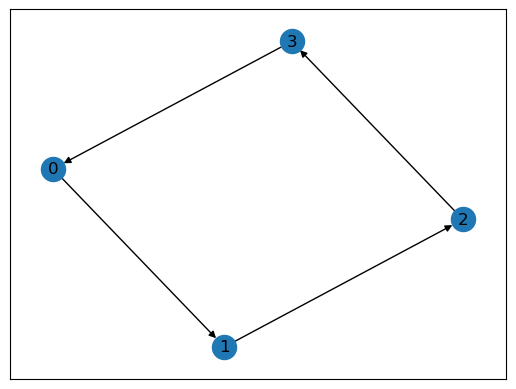

In [62]:
G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

In [63]:
seq_len = 1000
lossHistory = []

In [64]:
# Wout = torch.nn.Parameter(torch.randn(k, n_out).requires_grad_())
# bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())

In [65]:
import random
seed = 42
random.seed(seed)
N_data =  1
learningRate = 1e-2

torch.autograd.set_detect_anomaly(False)
optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)
extractor.train()
#---------------- FIRST PASS TO REDUCE THE LOSS TO A REASONABLE LEVEL ---------#
for i in range(N_data):
    l = torch.tensor(0.0)
    u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
    internal_state = torch.tensor(reservoir.run(u))
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    ctrnn = torch.zeros((seq_len, k))
    h_out, ctrnn[0] = extractor.forward(u[0], y_curr = y[0])
    y_out[0] = h_out
    y_t = y[0]
    loss = loss_fn(h_out.flatten().float(), y_t.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    for t in range(1,seq_len):
        # y_curr = y_out[t-1]
        y_curr = y[t-1]
        u_t = u[t]
        h_out, ctrnn[t] = extractor.forward(u_t, y_curr=y_curr)
        y_t = y[t]
        loss = loss_fn(h_out.flatten().float(), y_t.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l = (l.pow(2) + loss.detach().pow(2)).sqrt()
        y_out[t] = h_out.detach()
    
    plt.plot(ctrnn.detach()[:, 0], label='$y_1$')
    plt.plot(ctrnn.detach()[:, 1], label='$y_2$')
    plt.plot(ctrnn.detach()[:, 2], label='$y_3$')
    plt.plot(ctrnn.detach()[:, 3], label='$y_4$')
    plt.legend()
    plt.show()
    print(f'Loss at iteration {i} is {l: .5f}')
    lossHistory.append(l)


Running Reservoir-0: 100%|██████████| 1000/1000 [00:00<00:00, 8873.36it/s]


Loss at iteration 0 is  8.46234


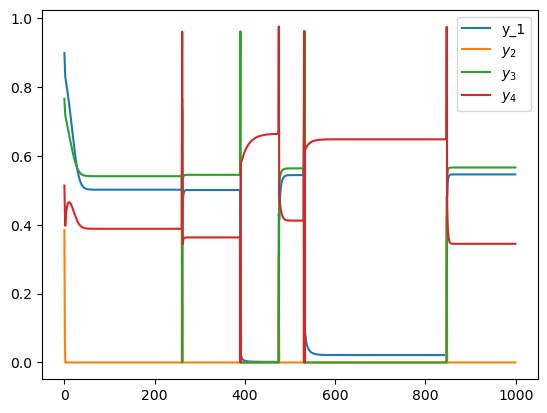

Running Reservoir-0:  24%|██▍       | 238/1000 [00:00<00:00, 1191.37it/s]

Running Reservoir-0: 100%|██████████| 1000/1000 [00:00<00:00, 1613.14it/s]


Loss at iteration 0 is  2.33250


C:\Users\mf572\AppData\Local\Temp\ipykernel_10952\3038720823.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u, y = torch.tensor(u), torch.tensor(y)


Loss at iteration 1 is  2.33020
Loss at iteration 2 is  2.32805
Loss at iteration 3 is  2.32604
Loss at iteration 4 is  2.32417
Loss at iteration 5 is  2.32240
Loss at iteration 6 is  2.32075
Loss at iteration 7 is  2.31920
Loss at iteration 8 is  2.31774
Loss at iteration 9 is  2.31636
Loss at iteration 10 is  2.31506
Loss at iteration 11 is  2.31383
Loss at iteration 12 is  2.31267
Loss at iteration 13 is  2.31156
Loss at iteration 14 is  2.31051
Loss at iteration 15 is  2.30952
Loss at iteration 16 is  2.30857
Loss at iteration 17 is  2.30767
Loss at iteration 18 is  2.30680
Loss at iteration 19 is  2.30597
Loss at iteration 20 is  2.30517
Loss at iteration 21 is  2.30439
Loss at iteration 22 is  2.30363
Loss at iteration 23 is  2.30289
Loss at iteration 24 is  2.30220
Loss at iteration 25 is  2.30153
Loss at iteration 26 is  2.30087
Loss at iteration 27 is  2.30024
Loss at iteration 28 is  2.29964
Loss at iteration 29 is  2.29906
Loss at iteration 30 is  2.29849
Loss at iteration 3

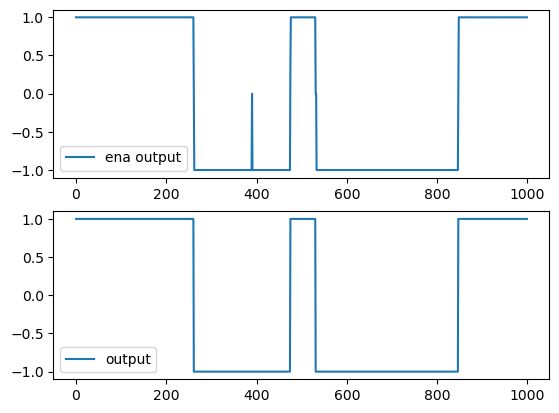

In [23]:
N_data =  100
learningRate = 1e-5
optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)
#-------------------- SECOND PASS TO AVOID ZIG-ZAGGING ------------------------#
u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
internal_state = torch.tensor(reservoir.run(u))
for i in range(N_data):
    l = torch.tensor(0.0)
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    h_out = extractor.forward(u[0], y_curr = y[0])
    y_out[0] = h_out
    y_t = y[0]
    loss = loss_fn(h_out.flatten().float(), y_t.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    for t in range(1,seq_len):
        y_curr = y[t-1]
        u_t = u[t]
        h_out = extractor.forward(u_t, y_curr=y_curr)
        y_t = y[t]
        loss = loss_fn(h_out.flatten().float(), y_t.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l = (l.pow(2) + loss.detach().pow(2)).sqrt()
        y_out[t] = h_out.detach()
    
    print(f'Loss at iteration {i} is {l: .5f}')
    lossHistory.append(l)



n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='ena output')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y[n_start:n_end], label = 'output')
plt.legend()
plt.show()

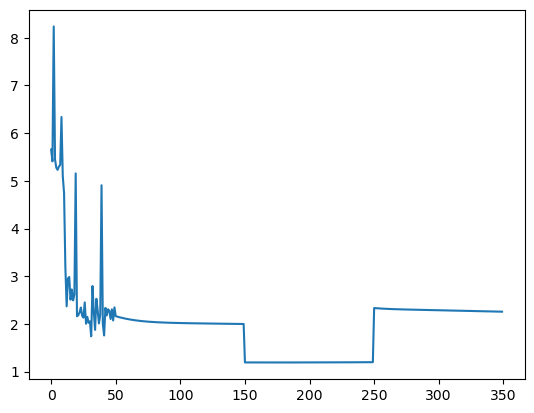

In [24]:
plt.plot(lossHistory)

In [ ]:
# test on a new dataset

seq_len = 2_000
u, y, _ = sequence(seq_len, q, 1, np.random.randint(0, 1e6))
# Wout_readout = torch.tensor(readout.params['Wout'])
# internal_state = torch.tensor(esn.run(u))
# internal_state = torch.tensor(reservoir.run(u))
u, y = torch.tensor(u), torch.tensor(y)
# y_out = torch.zeros((n_out, seq_len))
out = torch.zeros_like(y)
h_out = extractor.forward(u[0], y_curr = torch.zeros((1, n_out)))
out[0] = h_out
# h_out_all = torch.zeros_like((n_out, seq_len))

# Wout_readout = torch.tensor(readout.params['Wout'])
for t in range(1, seq_len):
    h_out = extractor.forward(u[t], y_curr=out[t-1])
    # h_out = extractor.forward(internal_state[t])
    out[t] = h_out
    # y_out_t = torch.matmul(h_out.float(), Wout.float()) + bias
    # y_out[t] = y_out_t
    # out[t] = torch.matmul(h_out.float(), Wout_readout.float())

In [ ]:
n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(out.detach().numpy()[n_start:n_end], label='ena output')
# plt.ylim([-1.2, 1.2])
plt.legend()
plt.subplot(2, 1, 2)
# plt.plot(internal_state.detach().numpy()[n_start:n_end, 1], label='actual')
plt.plot(y[n_start:n_end], label = 'output')
# plt.plot(u[n_start:n_end], label = 'input')
plt.legend()
plt.show()

In [ ]:
with open('ena_untrained_params.pkl', 'wb') as f:
    pickle.dump(extractor, f)

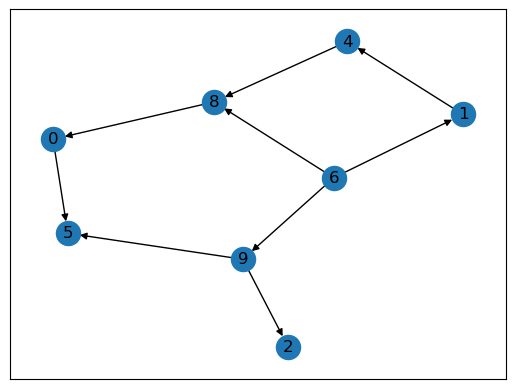

In [539]:
# with a random adjacency matrix
k = 10
n_out = 1
n_in = 1
# n = Wr.shape[0]
graph_seed = 3

A = torch.zeros((k, k))
A[0, 5] = 1
A[1, 4] = 1
A[4, 8] = 1
A[6, [1, 8, 9]] = 1
A[8, 0] = 1
A[9, [2, 5]] = 1
Wp = 0.01*torch.ones((k, k))
beta = torch.tensor(10.0)
# sparsity = 0.5*1/n
# def __init__(self, k, beta_init, p_init, w_p, n_out, A):
scaling = torch.tensor([0.1, 1, 1.0])
extractor = ENA_extractor(k, beta, p, Wp, n_out, n_in, scaling, A)
loss_fn = torch.nn.MSELoss()

G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

In [542]:
seq_len = 2000
lossHistory = []

Running Reservoir-11:   0%|          | 0/2000 [00:00<?, ?it/s]

Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 5374.92it/s]


Loss at iteration 0 is  0.0038


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 7186.23it/s]


Loss at iteration 1 is  0.0102


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 5063.44it/s]


Loss at iteration 2 is  0.0037


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 7832.32it/s]


Loss at iteration 3 is  0.0000


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 4807.95it/s]


Loss at iteration 4 is  0.0000


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 5319.04it/s]


Loss at iteration 5 is  0.0007


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 7369.50it/s]


Loss at iteration 6 is  0.0000


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 7632.42it/s]


Loss at iteration 7 is  0.0000


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 5794.36it/s]


Loss at iteration 8 is  0.0000


Running Reservoir-11: 100%|██████████| 2000/2000 [00:00<00:00, 5583.63it/s]


Loss at iteration 9 is  0.0000


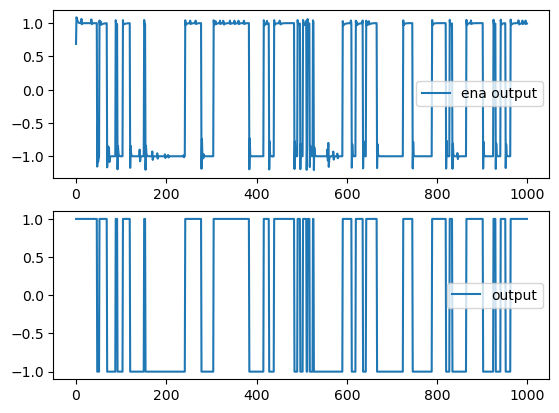

In [547]:
import random
seed = 42
random.seed(seed)
N_data =  10
learningRate = 1e-2

optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)

for i in range(N_data):
    l = torch.tensor(0.0)
    u, y, _ = sequence(seq_len, 0.1, 1, np.random.randint(0, 1e6))
    internal_state = torch.tensor(reservoir.run(u))
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    y_t = y[0]
    h_out = extractor.forward(u[0], y_curr = torch.zeros((1, n_out)))
    loss = (h_out - y_t).pow(2).sum()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    y_out[0] = h_out
    for t in range(1,seq_len):
        y_curr = y[t-1]
        # y_curr = y_out[t-1]
        h_out = extractor.forward(u[t], y_curr=y_curr)
        y_t = y[t]
        loss = (h_out - y_t).pow(2).sum()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        y_out[t] = h_out


    l = (l.pow(2) + loss.detach().pow(2)).sqrt()
    lossHistory.append(l)
    print(f'Loss at iteration {i} is {l: .4f}')

n_start = 0
n_steps = 1000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='ena output')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y[n_start:n_end], label = 'output')
plt.legend()
plt.show()

In [550]:
extractor.Wp[:9, :9]

tensor([[ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
         -3.5372],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100],
        [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
          0.0100]], grad_fn=<SliceBackward>)

In [ ]:
n_start = 0
n_steps = 1000
d = 0
# plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
plt.plot(u[n_start:(n_start + n_steps), d], label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y[n_start:(n_start + n_steps), d], label='output')
plt.legend()
plt.show()